In [1]:
# This will clone and install the branch that has the current changes on it. If you want to see the output of the install to be sure it 
# was successfull, remove the > /dev/null 2>&1 in the second line.  

#!pip install -e astrohack/ > /dev/null 2>&1
!pip install -e .. > /dev/null 2>&1

In [2]:
import os
import json
import astrohack

import numpy as np

In [3]:
os.getenv("SKRIBA_LOGGER_NAME")

'astrohack'

In [4]:
import distributed

from astrohack.client import local_client

DEFAULT_DASK_ADDRESS="tcp://localhost:8786"

log_params = {
    'logger_name': "astrohack",
    'log_level':'INFO'
}

if not distributed.client._get_global_client():
    try:
        client = distributed.Client(DEFAULT_DASK_ADDRESS, timeout=2)
        
    except OSError:
        os.environ["DASK_SCHEDULER_ADDRESS"] = DEFAULT_DASK_ADDRESS
        client=local_client(
            cores=2,
            memory_limit='8GB',
            log_params=log_params
        )
        
else:
    client = distributed.client._get_global_client()

#import logging
#logging.getLogger('numba').setLevel(logging.WARNING)

[ 2024-01-05 09:51:39,759 ]      INFO     astrohack:   Checking parameter values for client.local_client 
[ 2024-01-05 09:51:39,774 ]   WARNING     astrohack:   It is recommended that the local cache directory be set using the `local_dir` parameter. 
[ 2024-01-05 09:51:44,031 ]      INFO     astrohack:   Created client <Client: 'tcp://127.0.0.1:43513' processes=2 threads=2, memory=14.90 GiB> 


In [5]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [6]:
#ms_file = "/lustre/cv/users/jhoskins/otf33.ms"

#os.mkdir("data")
astrohack.data.datasets.download('ea25_cal_small_before_fixed.split.ms', folder="data", unpack=True)

ms_file = "data/ea25_cal_small_before_fixed.split.ms"

data/ea25_cal_small_before_fixed.split.ms.zip: 100%|██| 143M/143M [00:17<00:00, 8.58MiB/s]


In [7]:
from astrohack.extract_pointing import extract_pointing

point_mds = extract_pointing(
    ms_name=ms_file,
    point_name="data/ea25_cal_small_before_fixed.split.point.zarr",
    #exclude=["ea25"],
    parallel=True,
    overwrite=True
)

[ 2024-01-05 09:52:07,644 ]      INFO     astrohack:   Checking parameter values for extract_pointing.extract_pointing 
Successful readonly open of usernoread-locked table data/ea25_cal_small_before_fixed.split.ms/ANTENNA: 8 columns, 3 rows
[ 2024-01-05 09:52:14,569 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Writing pointing xds to data/ea25_cal_small_before_fixed.split.point.zarr/ant_ea25 
[ 2024-01-05 09:52:14,573 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   Writing pointing xds to data/ea25_cal_small_before_fixed.split.point.zarr/ant_ea04 
[ 2024-01-05 09:52:15,174 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   Writing pointing xds to data/ea25_cal_small_before_fixed.split.point.zarr/ant_ea06 
[ 2024-01-05 09:52:16,325 ]      INFO     astrohack:   Finished processing 


In [8]:
# Here I reduced the size of the holog_obs_dict for quicker testing. You can comment this out of edit it as needed depending on your testing goals.

from astrohack.extract_holog import generate_holog_obs_dict

holog_obs_dict = generate_holog_obs_dict(
    ms_name=ms_file,
    point_name="data/ea25_cal_small_before_fixed.split.point.zarr",
)

[ 2024-01-05 09:52:16,505 ]      INFO     astrohack:   Writing distance matrix to /export/home/ajax/jhoskins/Development/astrohack-logger-update/examples/.baseline_distance_matrix.csv ... 


### The holog observations dictionary has now been turned into an extended dictionary object similar to the `holog_mds`. There are a couple of new functionalities available to the user now:

- The `select` function allows the user to trim the holog_obs_dict on all major axes (ddi, map, antenna, scan, baseline) in a much simpler way than previsouly.
- The `print` function allows the user to inspect the holog_obs_dict with both a static, ascii print out style and a dynamic, collapsible json style.
- A static method is available to allow the user to select the `n` closest baseline associated with a given mapping antenna adn return them in a list that cane be used with the baseline key option allowing the user to trim the holog_obs_dict based on baseline.

### Each of these options is demonstrated below.

In [9]:
#get_nearest_baselines(antenna="ea25", n_baselines=5)

In [10]:
# There are two options here for style, static and dynamic. Static returns a formatted ascii output while dynamic returns a dynamic json object.
holog_obs_dict.print(style="dynamic")

<IPython.core.display.JSON object>

In [11]:
from astrohack.extract_holog import model_memory_usage

memory_per_core = model_memory_usage(
    ms_name=ms_file, 
    holog_obs_dict=holog_obs_dict
)

model/elastic.model: 100%|██████████████████████████████| 556/556 [00:00<00:00, 3.35MiB/s]


                                      System Info                                       
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ N-cores ┃ Available memory (MB) ┃ Total memory (MB) ┃ Suggested memory per core (MB) ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       4 │ 2686                  │ 15893             │                          11911 │
└─────────┴───────────────────────┴───────────────────┴────────────────────────────────┘
    Available memory: represents the system memory available without going into swap    

### `Select(key, value, inplace, **kwargs)`
### The select function allows the user to trim the `holog_obs_dict`. The `key` (ddi, map, antenna, scan, baseline) input gives the dictionary key you would like to select and `value` is the value you want to keep. Everything else is deleted. There is also an `inplace` boolean input. This specifies whether you want to modify the calling dictionay or return a new dictionary. The additional arguments, `kwarags` is currently only useful for the baseline example explain further down.

### One key feature is also that all select calls are chainable. This allows for selecting on mutiple keys in a simple modular way. An example is shown below.

In [12]:
# Select only ddi=0 and return a new dictionary, from the original dictionary above.
#trimmed_dict = holog_obs_dict.select(key="ddi", value=1, inplace=False)
#trimmed_dict.print(style="dynamic")

In [13]:
# Here we will select only following (key,value) pairs: 
#
# ddi=0
# map=0
# scans=6, 7, 8, 9, 10
# antenna='ea22', 'ea15', 'ea25'
#
# We do this using function chaining. Because each call returns a new object, another call can be directly invoked.

#trimmed_dict = holog_obs_dict.select(
#    key="ddi", 
#    value=0, 
#    inplace=False
#).select(
#    key="map", 
#    value=0, 
#    inplace=False
#).select(
#    key="scan", 
#    value=[6, 7, 8, 9, 10], 
#    inplace=False
#).select(
#    key="antenna", 
#    value=['ea22', 'ea15', 'ea25'], 
#    inplace=False
#)

#trimmed_dict.print(style="dynamic")

### `Select(...)` with the baseline option:

### In order to trim the dictionary based on the shortest baseline formed using a given mapping antenna we require the use of two functions. First we use the static method to get the reference antennas that for the `n` shortest baselines given and antenna.

In [14]:
# Since it doesn't mdoify the dictionary object, this can be called on the new returned dictionary or the original dictionary. The following 
# gives the antennas for the three shortest baselines formed with the mapping antenna, 'ea25'. Note these don't take into account whether the 
# antenna is reference or mapping, it only calculates the baseline lengths for reference.
#nearest_baselines = holog_obs_dict.get_nearest_baselines(antenna="ea15", n_baselines=24)
#nearest_baselines
#
#.select(
#    key="scan", 
#    value=[
#        6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
#        16, 17, 19, 20, 21, 22, 23, 24, 25, 
#        26, 27, 28, 29, 30, 35, 36, 37, 38, 
#        39, 40
#    ],
#    inplace=False
#)

In [15]:
# With the reference antenna list in-hand we can now trim the dictionary using the select method as follows
'''
trimmed_dict = {}

trimmed_dict = holog_obs_dict.select(
    key="ddi", 
    value=1,
    inplace=False
).select(
    key="baseline", 
    value="ea15", 
    n_baselines=3, 
    inplace=False
)

trimmed_dict.print(style="dynamic")
'''

'\ntrimmed_dict = {}\n\ntrimmed_dict = holog_obs_dict.select(\n    key="ddi", \n    value=1,\n    inplace=False\n).select(\n    key="baseline", \n    value="ea15", \n    n_baselines=3, \n    inplace=False\n)\n\ntrimmed_dict.print(style="dynamic")\n'

In [16]:
# You will notice that there is a warning thrown below regarding the mutliple values of cell size and pixel number found in the pointing file
# but suggested values are computed. They are NOT guarenteed to work though. For instance, below you will see the number of pixels is very small
# and if you use the resonably calculated pixle value suggested, you will get a singular matrix. There is still work to be done.

from astrohack.extract_holog import extract_holog

holog_mds = extract_holog(
    ms_name=ms_file,
    point_name="data/ea25_cal_small_before_fixed.split.point.zarr",
    #holog_name="data/otf33.holog.zarr",
    #holog_obs_dict=trimmed_dict,
    data_column='CORRECTED_DATA',
    parallel=True,
    overwrite=True
)

[ 2024-01-05 09:52:18,705 ]      INFO     astrohack:   Checking parameter values for extract_holog.extract_holog 
[ 2024-01-05 09:52:18,715 ]      INFO     astrohack:   Creating output file name: data/ea25_cal_small_before_fixed.split.holog.zarr 
[ 2024-01-05 09:52:18,760 ]      INFO     astrohack:   Processing ddi: 0, scans: [8 ... 57] 
[ 2024-01-05 09:52:18,763 ]      INFO     astrohack:   Processing ddi: 1, scans: [8 ... 57] 
Successful readonly open of default-locked table data/ea25_cal_small_before_fixed.split.ms/ANTENNA: 8 columns, 3 rows
Successful readonly open of default-locked table data/ea25_cal_small_before_fixed.split.ms/OBSERVATION: 9 columns, 1 rows
[ 2024-01-05 09:52:25,410 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Writing holog file to data/ea25_cal_small_before_fixed.split.holog.zarr 
[ 2024-01-05 09:52:25,539 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Writing holog file to data/ea25_cal_small_before_fixed.spl

In [17]:
from astrohack.holog import holog

image_mds = holog(
    holog_name="data/ea25_cal_small_before_fixed.split.holog.zarr",
    #grid_size=np.array([30, 30]),
    overwrite=True,
    parallel=True
)

[ 2024-01-05 09:52:25,995 ]      INFO     astrohack:   Checking parameter values for holog.holog 
[ 2024-01-05 09:52:26,178 ]      INFO     astrohack:   Creating output file name: data/ea25_cal_small_before_fixed.split.image.zarr 
[ 2024-01-05 09:52:26,183 ]      INFO     astrohack:   Cell size: [-0.00064425  0.00064425], Grid size [31 31] 
[ 2024-01-05 09:52:26,612 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Calculating aperture pattern ... 
[ 2024-01-05 09:52:26,612 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Calculating aperture illumination pattern ... 
[ 2024-01-05 09:52:26,647 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   Calculating aperture pattern ... 
[ 2024-01-05 09:52:26,647 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   Calculating aperture illumination pattern ... 
[ 2024-01-05 09:52:26,791 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   Apply

[ 2024-01-05 09:52:31,279 ]      INFO     astrohack:   Checking parameter values for mds.AstrohackImageFile.plot_apertures 


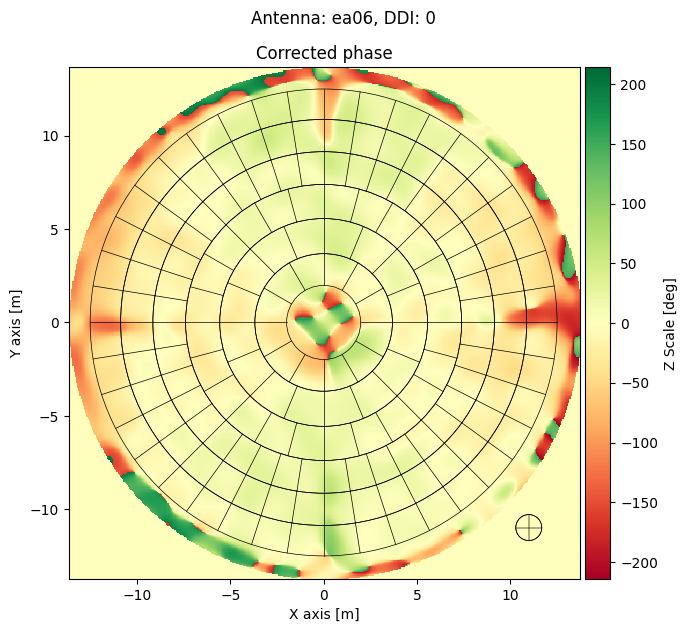

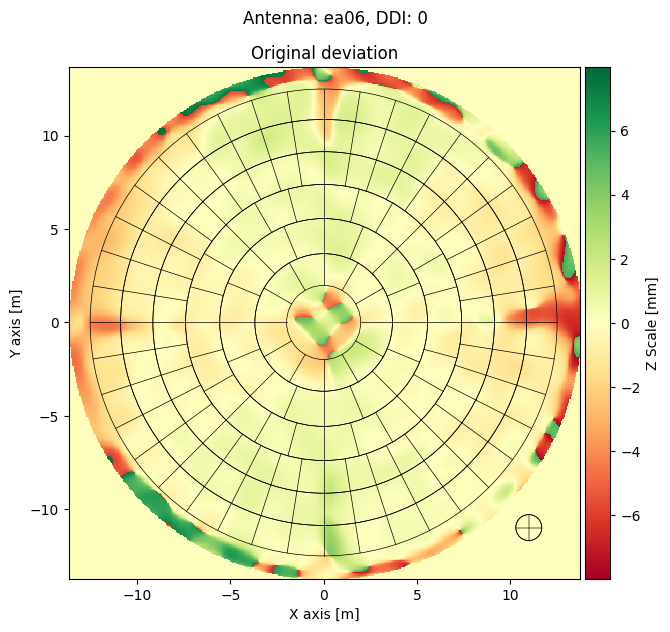

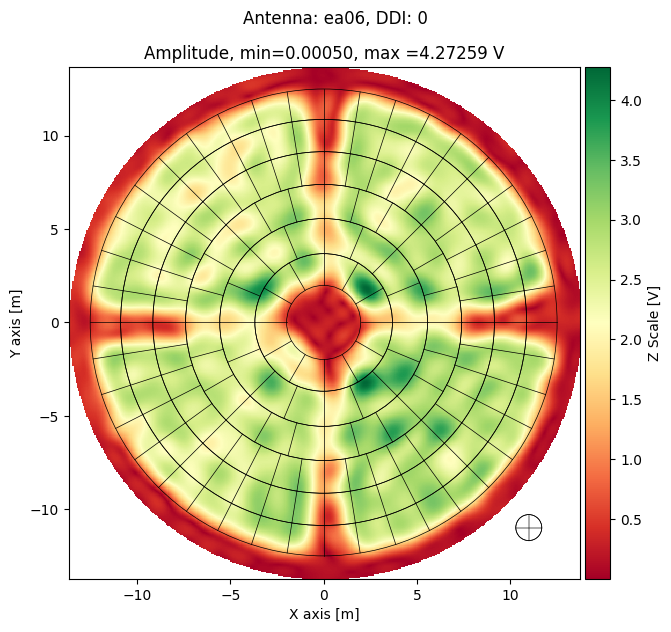

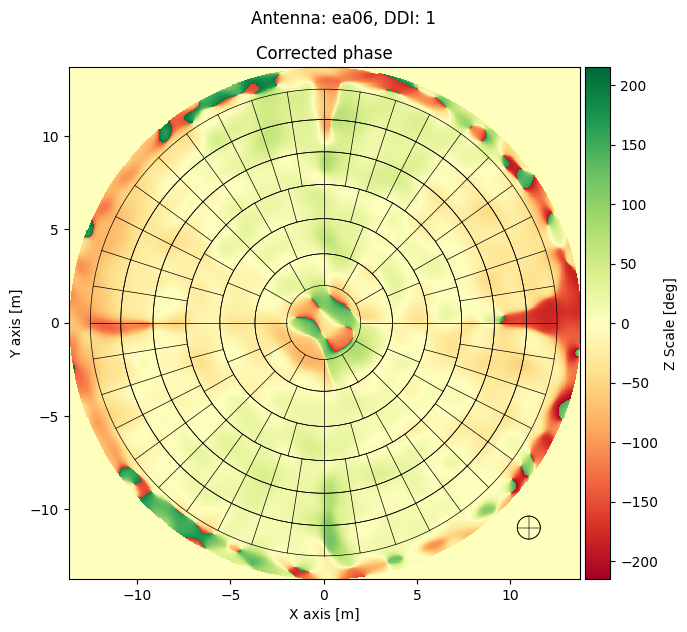

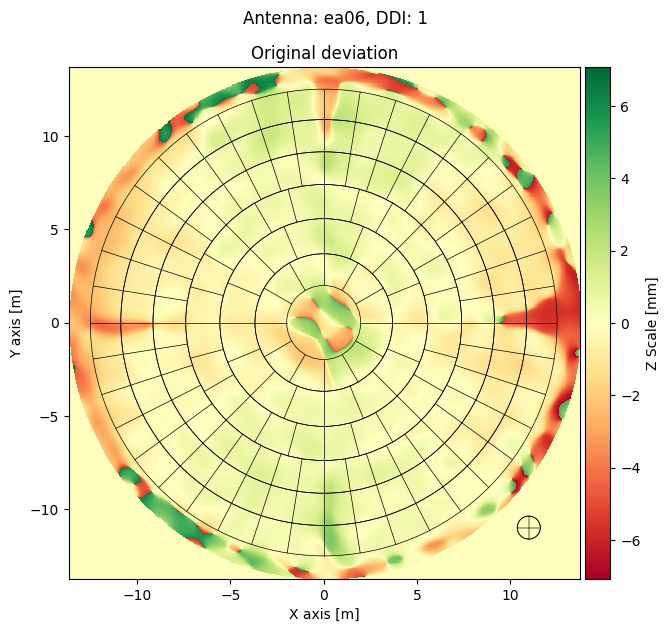

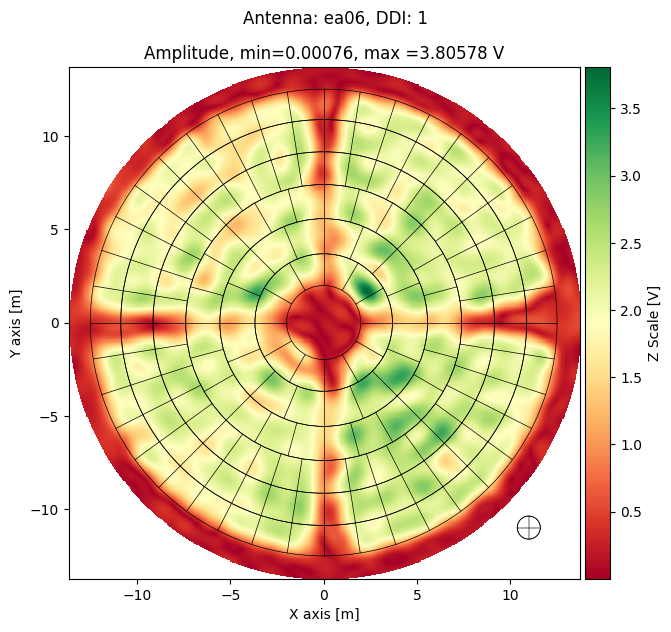

In [18]:
#
# A list of colormaps available in matplotlib can be found here:
#
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
#

image_mds.plot_apertures(
    destination="plots", 
    ant="ea06",
    colormap="RdYlGn",
    display=True
)

In [19]:
from astrohack.panel import panel

panel_model = 'rigid'

panel_mds = panel(
    image_name='data/ea25_cal_small_before_fixed.split.image.zarr', 
    panel_model=panel_model, 
    panel_margins=0.2,
    clip_type='relative',
    clip_level=0.2,
    parallel=True,
    overwrite=True
)

[ 2024-01-05 09:52:38,221 ]      INFO     astrohack:   Checking parameter values for panel.panel 
[ 2024-01-05 09:52:38,225 ]      INFO     astrohack:   Creating output file name: data/ea25_cal_small_before_fixed.split.panel.zarr 
[ 2024-01-05 09:52:38,454 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   processing ant_ea06 ddi_1 
[ 2024-01-05 09:52:38,611 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   processing ant_ea06 ddi_0 
[ 2024-01-05 09:52:39,929 ]      INFO    astrohack_Worker-61788caf-9322-42d4-98b5-36f60dfc98f5:   processing ant_ea25 ddi_0 
[ 2024-01-05 09:52:40,512 ]      INFO    astrohack_Worker-4a298366-de57-4970-aa1f-3388ad712976:   processing ant_ea25 ddi_1 
[ 2024-01-05 09:52:41,770 ]      INFO     astrohack:   Finished processing 


[ 2024-01-05 09:52:41,860 ]      INFO     astrohack:   Checking parameter values for mds.AstrohackPanelFile.plot_antennas 


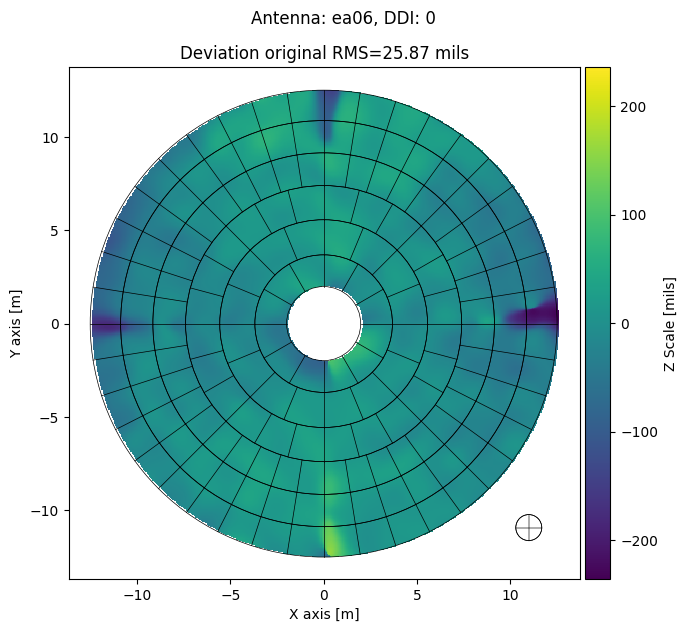

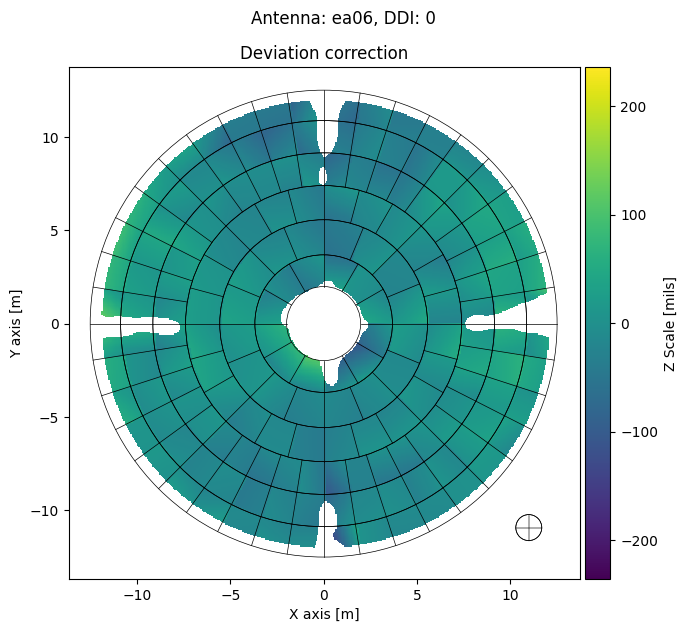

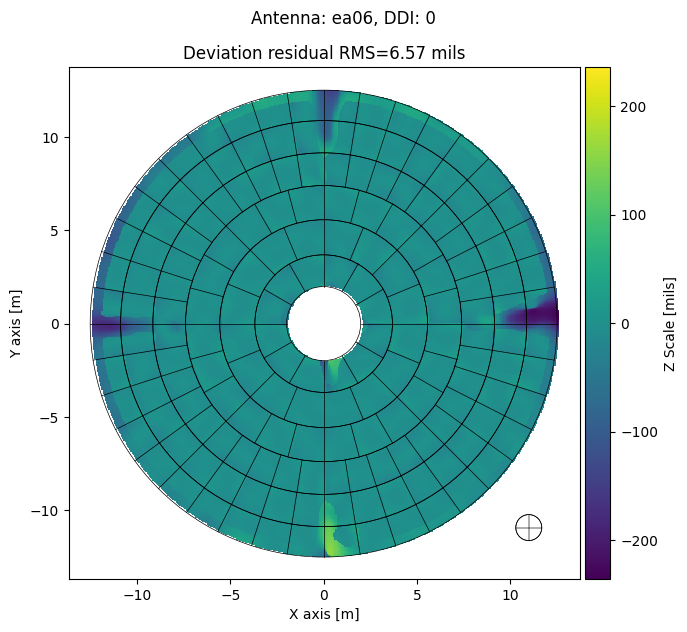

In [20]:
panel_mds.plot_antennas(
    "panel_exports",         # Directory to contain the plot and text file
    ant='ea06',              # Plotting Antenna ea06
    ddi=0,                   # Plotting DDI 0
    plot_type='deviation',   # Do deviation plots only
    deviation_unit='mils',   #
    plot_screws=False,       # Not plotting screw positions
    parallel=False,          # Don't do plots in parallel
    display=True             # Display plots below
)

In [21]:
client.shutdown()